# 北航软件学院人工智能作业一演示

In [61]:
# 导入本次演示必要的库
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def plot_data_internal(X, y):
    x_min, x_max = X[ :, 0 ].min() - .5, X[ :, 0 ].max() + .5
    y_min, y_max = X[ :, 1 ].min() - .5, X[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    plt.figure()
    plt.xlim(xx.min(None), xx.max(None))
    plt.ylim(yy.min(None), yy.max(None))
    ax = plt.gca()
    ax.plot(X[y == 0, 0], X[y == 0, 1], 'ro', label = 'Class 1')
    ax.plot(X[y == 1, 0], X[y == 1, 1], 'bo', label = 'Class 2')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Plot data')
    plt.legend(loc = 'upper left', scatterpoints = 1, numpoints = 1)
    return xx, yy

# 预览数据
def plot_data(X, y):
    plot_data_internal(X, y)
    plt.show()

# 预览损失
def plot_loss(ll):
    plt.figure()
    ax = plt.gca()
    plt.xlim(0, len(ll) + 2)
    plt.ylim(min(ll) - 0.1, max(ll) + 0.1)
    ax.plot(np.arange(1, len(ll) + 1), ll, 'r-')
    plt.xlabel('Steps')
    plt.ylabel('Average Cross Entropy Loss')
    plt.title('Plot Cross Entropy Loss Curve')
    plt.show()

# 混淆矩阵
def confusion_matrix(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    return np.array([[tn, fp],
                     [fn, tp]])

In [62]:
# 读取数据
txt_path = './data/txt_data.txt' # txt格式: 存储文本，可以直接预览
npy_path = './data/npy_data.npy' # npy格式: 用于存储单个numpy数组的二进制格式
npz_path = './data/npz_data.npz' # npz格式: 用于存储多个numpy数组的压缩格式

read_txt = np.loadtxt(txt_path)
read_np = np.load(npy_path)
read_npz = np.load(npz_path)

os.path.getsize(txt_path), os.path.getsize(npy_path), os.path.getsize(npz_path)

(76069, 24128, 24490)

- 预测任务：$f(x_1, x_2) → [p_0, p_1]$，其中$x_i$为点坐标，$p_j$为属于第j类的概率
- 线性回归：$f(x_1, x_2) = \sigma([w_1, w_2] \cdot [x_1, x_2] ^ T +b)$，等价于$\sigma([w_1, w_2, w_3] \cdot [x_1, x_2, 1] ^ T)$


In [63]:
# 读取、检查数据

data = read_txt

# data = read_np # 这段代码的作用和上一段一样，替换下试试

# data = np.concatenate([read_npz['x'], np.expand_dims(read_npz['y'], axis=1)], axis=1) # 这段代码的作用和上一段一样，替换下试试

data[:5] 

array([[-0.62294615, -0.57879556,  0.        ],
       [ 1.09961316,  1.55006583,  0.        ],
       [ 0.75478522, -1.97615881,  1.        ],
       [-1.13634801, -0.0386258 ,  1.        ],
       [-0.12266627, -1.85082517,  1.        ]])

In [64]:
# 生成随机排列
permutation = np.random.permutation(data.shape[0])
data = data[permutation]
data[:5]

array([[-1.30700863,  0.33824781,  1.        ],
       [ 0.48700455, -0.68155787,  0.        ],
       [-1.56096698, -1.82222131,  0.        ],
       [-1.57587088, -1.17730481,  0.        ],
       [ 0.26944715,  0.00781522,  0.        ]])

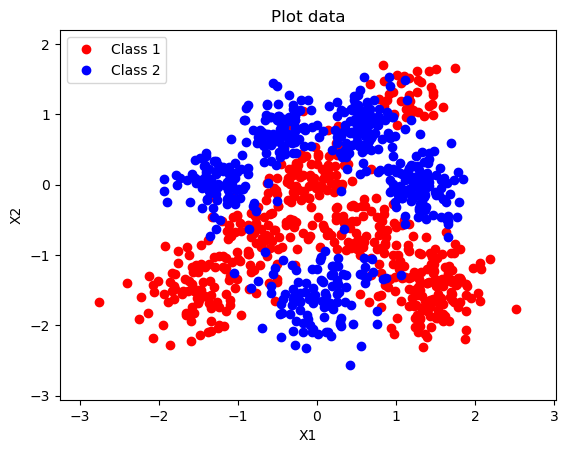

In [65]:
plot_data(data[ :, :2], data[ :, 2])

In [ ]:
# 划分训练集、测试集
n_train = 800
X = data[ :, :2] # 1000 x 2
y = data[ :, 2 ] # 1000
X_train = X[ 0 : n_train, : ] # 800 x 2
X_test = X[ n_train :, : ] # 200 x 2
y_train = y[ 0 : n_train ] # 800
y_test = y[ n_train : ] # 200

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

# 手工实现logistic回归

- logistic 函数：$f(x) = \frac{1}{1 + e^{-x}}$
- 预测函数（简单的线性变换）：$X\in\mathbb{R}^{N_{train} \times 2}, w \in\mathbb{R}^{2}, Xw \in\mathbb{R}^{N_{train}}$
- 对数似然：$\text{LogLikelihood} = y \text{log}(\hat{y}) + (1-y) \text{log}(1-\hat{y})$
    - 当$y = 0$，有$\text{Loss} = \text{log}(1 - \hat{y})$
    - 当$y = 1$，有$\text{Loss} = \text{log}(\hat{y})$
- 交叉熵损失：$\text{Loss} = - [y \text{log}(\hat{y}) + (1-y) \text{log}(1-\hat{y})]$
    - 当$y = 0$，有$\text{Loss} = - \text{log}(1 - \hat{y})$
    - 当$y = 1$，有$\text{Loss} = - \text{log}(\hat{y})$

In [ ]:
# logistic regression 的手工实现

# logistic 函数
def logistic(x): return 1.0 / (1.0 + np.exp(-x)) # N -> N

# 预测函数
def predict(X_tilde, w): return logistic(np.dot(X_tilde, w)) # N x (D + 1) -> N

# 计算平均对数似然
def compute_average_ll(X_tilde, y, w):
    output_prob = predict(X_tilde, w)
    return np.mean(y * np.log(output_prob) + (1 - y) * np.log(1.0 - output_prob)) 

# 添加偏置项
def get_x_tilde(X): return np.concatenate((np.ones((X.shape[ 0 ], 1 )), X), 1)

# 梯度下降函数
# TODO: 试试把一层的logistic regression改成多层的logistic regression，观察效果是否会提升
def fit_w(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha):
    w = np.random.randn(X_tilde_train.shape[ 1 ]) 
    ll_train = np.zeros(n_steps)
    ll_test = np.zeros(n_steps)
    for i in range(n_steps):
        sigmoid_value = predict(X_tilde_train, w)

        w = w + alpha * np.dot(X_tilde_train.T, (y_train - sigmoid_value)) # TODO: 试试加入L2正则化，观察效果是否会提升

        ll_train[ i ] = compute_average_ll(X_tilde_train, y_train, w)
        ll_test[ i ] = compute_average_ll(X_tilde_test, y_test, w)
        print(f'epoch {i+1}: train loss: {-ll_train[ i ]}, test loss: {-ll_test[ i ]}')

    return w, ll_train, ll_test

epoch 1: train loss: 1.4979700848457584, test loss: 1.637620957340315
epoch 2: train loss: 1.4213832772625787, test loss: 1.5538535497963482
epoch 3: train loss: 1.3478134924545802, test loss: 1.4733577784759821
epoch 4: train loss: 1.2776004766217677, test loss: 1.3964962042744724
epoch 5: train loss: 1.211069242566972, test loss: 1.323614465684891
epoch 6: train loss: 1.1485131828908106, test loss: 1.255023458705611
epoch 7: train loss: 1.0901764758476609, test loss: 1.190980991893557
epoch 8: train loss: 1.0362377806756193, test loss: 1.1316750190362177
epoch 9: train loss: 0.9867974257177604, test loss: 1.0772107077513147
epoch 10: train loss: 0.9418700328526199, test loss: 1.0276032721351078
epoch 11: train loss: 0.9013837779464319, test loss: 0.9827776873472138
epoch 12: train loss: 0.8651864146525784, test loss: 0.9425752936472098
epoch 13: train loss: 0.8330570753155325, test loss: 0.906766186555272
epoch 14: train loss: 0.8047220147733383, test loss: 0.8750654787736326
epoch 1

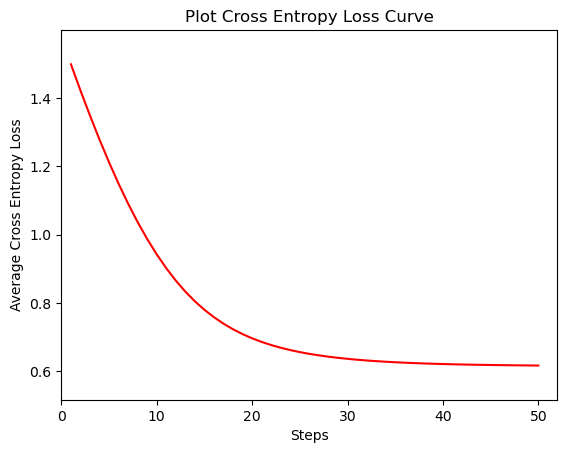

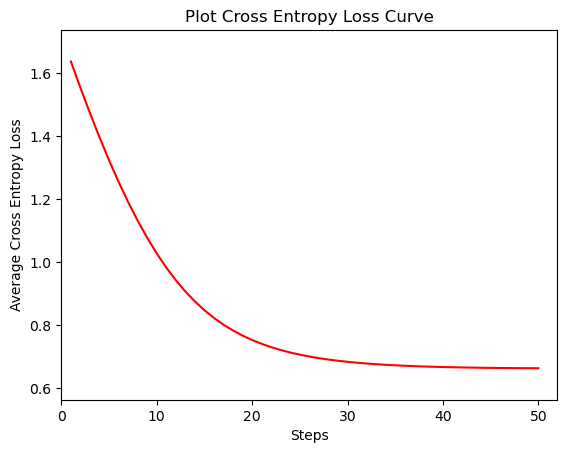

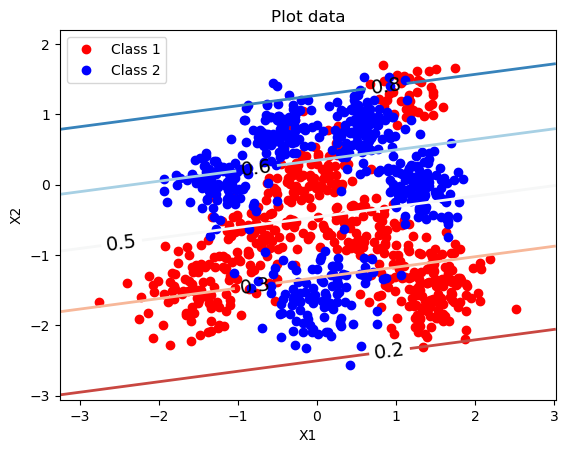

In [68]:
# 预览决策边界
def plot_predictive_distribution(X, y, w, map_inputs = lambda x : x):
    xx, yy = plot_data_internal(X, y)
    ax = plt.gca()
    X_tilde = get_x_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = predict(X_tilde, w)
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 2)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.show()

alpha = 0.0005 # 学习率，试着自己调整一下
n_steps = 50 # epoch迭代次数，试着自己调整一下

X_tilde_train = get_x_tilde(X_train)
X_tilde_test = get_x_tilde(X_test)
w, ll_train, ll_test = fit_w(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha)

X_tilde_test = get_x_tilde(X_test)
y_pred_prob = predict(X_tilde_test, w)
y_pred = (y_pred_prob >= 0.5).astype(int)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", np.mean(y_test == y_pred))
# 阅读文档，理解报告里每个指标的含义
# https://blog.csdn.net/weixin_62528784/article/details/145379239
print("Classification Report (scikit-learn):")
print(classification_report(y_test, y_pred))

plot_loss(-ll_train)
plot_loss(-ll_test)
plot_predictive_distribution(X, y, w)

![image.png](https://s2.loli.net/2025/03/03/QOCGngtfVIM9D6k.png)

In [69]:
# 核函数：用于扩充数据维度，常常用于SVM
# polar: 极坐标核，用来把直角坐标点转换为极坐标点
def polar(coords):
    x = coords[ :, 0 ]
    y = coords[ :, 1 ]
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return np.column_stack((r, theta))

# 极坐标绘图函数
def polar_draw(a, b, c):
    theta = np.linspace(0, 10 * np.pi, 1000)
    # 计算 r 值
    r = - (a / b) * theta - (c / b)
    # 过滤掉负半径的部分（因为 r 必须是非负数）
    valid_idx = r >= 0
    r = r[valid_idx]
    theta = theta[valid_idx]
    # 转换为笛卡尔坐标
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    # 画图
    plt.figure(figsize=(4, 4))
    plt.plot(x, y)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.legend()
    plt.axis("equal")
    plt.grid()
    plt.show()
    
X_tilde_train = get_x_tilde(polar(X_train))
X_tilde_test = get_x_tilde(polar(X_test))
X_tilde_train[:5], X_tilde_test[:5]

(array([[ 1.        ,  1.35006783,  2.88835326],
        [ 1.        ,  0.83767211, -0.95037442],
        [ 1.        ,  2.39939751, -2.2791261 ],
        [ 1.        ,  1.96708303, -2.49996167],
        [ 1.        ,  0.26956047,  0.02899653]]),
 array([[ 1.        ,  1.38924382,  2.97721543],
        [ 1.        ,  2.21909599, -1.77591382],
        [ 1.        ,  1.12729181,  2.973256  ],
        [ 1.        ,  0.54871665, -3.05954427],
        [ 1.        ,  1.28142947, -2.96677889]]))

epoch 1: train loss: 1.8260131907387773, test loss: 1.8149399952165606
epoch 2: train loss: 1.6123611522762333, test loss: 1.6196876081214848
epoch 3: train loss: 1.4133316287382403, test loss: 1.4361584849635785
epoch 4: train loss: 1.2318603746323769, test loss: 1.2671819017068766
epoch 5: train loss: 1.0719731793671061, test loss: 1.1167497145619136
epoch 6: train loss: 0.9381003017572753, test loss: 0.9893450127825386
epoch 7: train loss: 0.8333563921112151, test loss: 0.8882593488119451
epoch 8: train loss: 0.7574457398987581, test loss: 0.8135823557801222
epoch 9: train loss: 0.7061182715986861, test loss: 0.7616954563815709
epoch 10: train loss: 0.6730221890133388, test loss: 0.726986386699605
epoch 11: train loss: 0.6521481061899528, test loss: 0.7040730858696103
epoch 12: train loss: 0.6390230358271373, test loss: 0.6888880005341679
epoch 13: train loss: 0.6307076015715986, test loss: 0.6786978007903284
epoch 14: train loss: 0.6253738270968896, test loss: 0.6717507341758505
ep

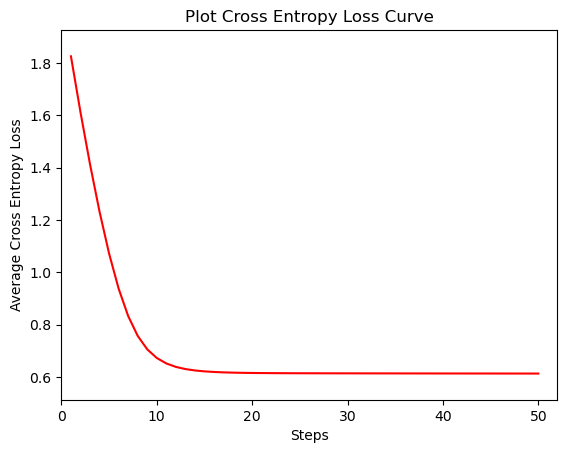

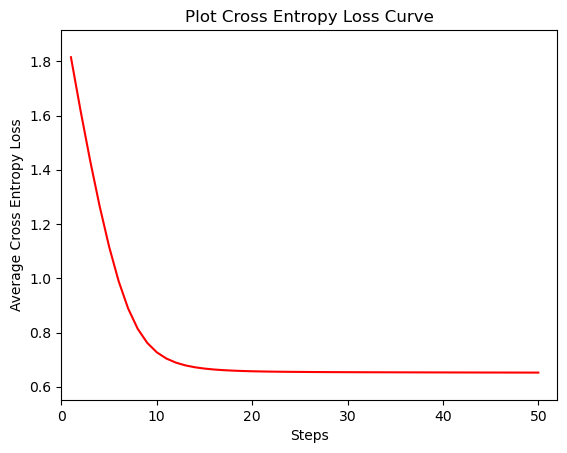

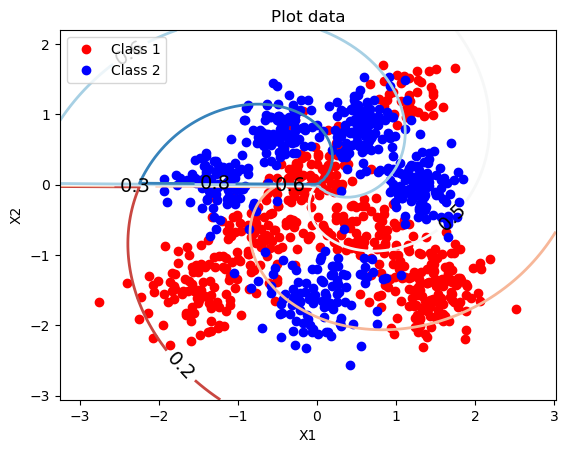

/var/folders/dv/882dxcks2c78wz1dfm9f0ghm0000gn/T/ipykernel_13468/4045588789.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


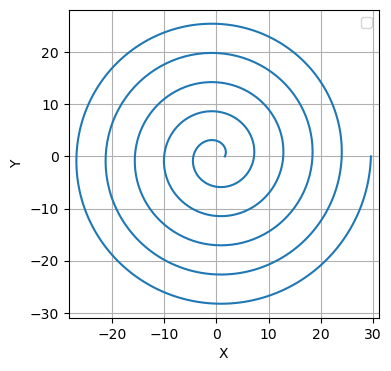

In [70]:
alpha = 0.0005 # 学习率，试着自己调整一下
n_steps = 50 # epoch迭代次数，试着自己调整一下

# 这里使用极坐标做线性回归，实际上是用阿基米德螺旋线做分类
w, ll_train, ll_test = fit_w(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha)

X_tilde_test_polar = get_x_tilde(polar(X_test))
y_pred_prob = predict(X_tilde_test_polar, w)
y_pred = (y_pred_prob >= 0.5).astype(int)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", np.mean(y_test == y_pred))
print("Classification Report (scikit-learn):")
print(classification_report(y_test, y_pred))

plot_loss(-ll_train)
plot_loss(-ll_test)
plot_predictive_distribution(X, y, w, polar)

c, b, a = w
polar_draw(a, b, c)

In [71]:
# 核函数：用于扩充数据维度，常常用于SVM
# Radial Basis Function (RBF)： 定义为空间中任一点x到某一中心xc之间欧氏距离的单调函数，若两点距离很近则接近1，如果距离很远就接近0
# TODO: 尝试使用其他的核函数，观察效果是否会提升
def RBF(l, X, Z):
    X2 = np.sum(X**2, 1)
    Z2 = np.sum(Z**2, 1)
    ones_Z = np.ones(Z.shape[ 0 ])
    ones_X = np.ones(X.shape[ 0 ])
    r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
    return np.exp(-0.5 / l**2 * r2)

l = 0.1 # 高斯核函数的宽度，试着自己调整一下？

X_tilde_train = get_x_tilde(RBF(l, X_train, X_train))
X_tilde_test = get_x_tilde(RBF(l, X_test, X_train))

X_tilde_train[:5], X_tilde_test[:5]

(array([[1.00000000e+000, 1.00000000e+000, 3.37389630e-093, ...,
         3.70065937e-142, 2.32903834e-083, 3.07639456e-173],
        [1.00000000e+000, 3.37389630e-093, 1.00000000e+000, ...,
         1.59955546e-009, 3.82545186e-042, 1.58190296e-047],
        [1.00000000e+000, 1.75098806e-103, 4.68885461e-120, ...,
         7.37602205e-192, 1.21152343e-240, 7.60511601e-063],
        [1.00000000e+000, 3.57902968e-052, 1.80820744e-098, ...,
         7.21471014e-166, 1.30103430e-180, 9.82429941e-081],
        [1.00000000e+000, 4.60629400e-057, 4.49379273e-012, ...,
         1.57491691e-021, 1.75461198e-013, 9.52954068e-098]]),
 array([[1.00000000e+000, 4.41855390e-001, 1.37283715e-093, ...,
         4.58687131e-145, 1.02075508e-090, 9.45440636e-166],
        [1.00000000e+000, 1.69993443e-153, 3.79347768e-068, ...,
         4.87475523e-113, 1.08555303e-203, 1.22525508e-007],
        [1.00000000e+000, 4.83318488e-002, 1.18044997e-072, ...,
         1.61548448e-117, 1.10055942e-070, 1.016893

epoch 1: train loss: 0.9951607570239465, test loss: 1.033215990598017
epoch 2: train loss: 0.9849715164191305, test loss: 1.0242787015653305
epoch 3: train loss: 0.9755295559922996, test loss: 1.0160610404135437
epoch 4: train loss: 0.9667500961144734, test loss: 1.008478036253276
epoch 5: train loss: 0.9585574750147714, test loss: 1.0014537948763371
epoch 6: train loss: 0.9508843803896885, test loss: 0.9949207914825342
epoch 7: train loss: 0.9436710947089386, test loss: 0.9888191567469592
epoch 8: train loss: 0.93686476880124, test loss: 0.9830959753615389
epoch 9: train loss: 0.9304187337038468, test loss: 0.9777046108846398
epoch 10: train loss: 0.9242918570758556, test loss: 0.9726040663719602
epoch 11: train loss: 0.9184479475976371, test loss: 0.9677583867660874
epoch 12: train loss: 0.9128552085888684, test loss: 0.9631361062899747
epoch 13: train loss: 0.9074857404595792, test loss: 0.958709742010598
epoch 14: train loss: 0.9023150904552384, test loss: 0.954455333203789
epoch 1

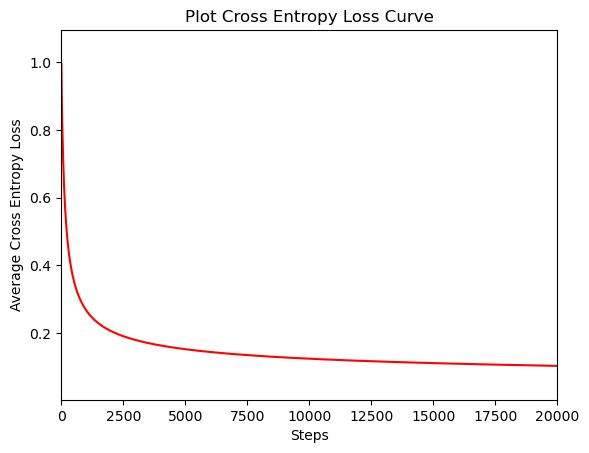

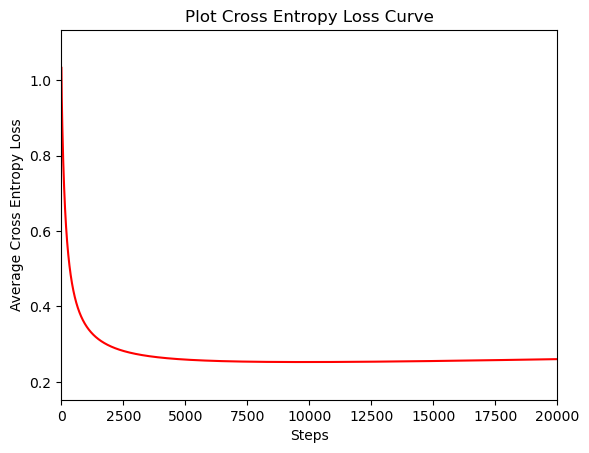

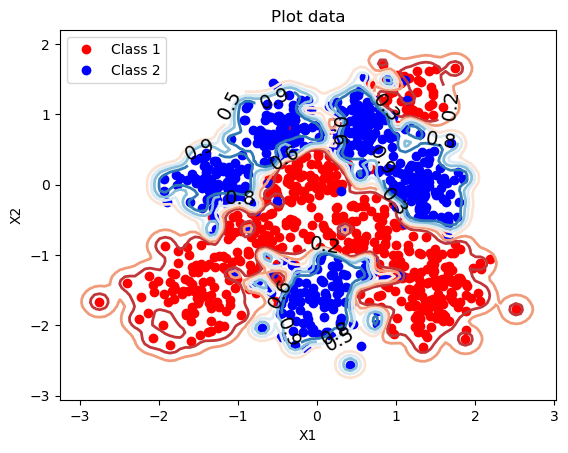

In [72]:
alpha = 0.0005 # 学习率，试着自己调整一下
n_steps = 20000 # epoch迭代次数，试着自己调整一下

w, ll_train, ll_test = fit_w(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha)

X_tilde_test_rbf = get_x_tilde(RBF(l, X_test, X_train))
y_pred_prob = predict(X_tilde_test_rbf, w)
y_pred = (y_pred_prob >= 0.5).astype(int)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", np.mean(y_test == y_pred))
print("Classification Report (scikit-learn):")
print(classification_report(y_test, y_pred))

plot_loss(-ll_train)
plot_loss(-ll_test)
plot_predictive_distribution(X, y, w, lambda x : RBF(l, x, X_train))

In [73]:
# 调用逻辑斯谛回归的轮子，看看效果如何
model = LogisticRegression() 
model.fit(X_tilde_train, y_train)

# 预测
y_pred_sklearn = model.predict(X_tilde_test)

# 输出评价指标
print("Confusion Matrix (scikit-learn):")
print(confusion_matrix(y_test, y_pred_sklearn))
print("Accuracy (scikit-learn):", accuracy_score(y_test, y_pred_sklearn))
print("Classification Report (scikit-learn):")
print(classification_report(y_test, y_pred_sklearn))

Confusion Matrix (scikit-learn):
[[89  5]
 [15 91]]
Accuracy (scikit-learn): 0.9
Classification Report (scikit-learn):
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90        94
         1.0       0.95      0.86      0.90       106

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



In [74]:
# 调用强大的分类器SVM试试
model = SVC(kernel='rbf', C=50, gamma='scale') # TODO: 研究这里参数的含义，试着调整调整参数
model.fit(X_tilde_train, y_train)

# 预测
y_pred_sklearn = model.predict(X_tilde_test)

# 输出评价指标
print("Confusion Matrix (scikit-learn):")
print(confusion_matrix(y_test, y_pred_sklearn))
print("Accuracy (scikit-learn):", accuracy_score(y_test, y_pred_sklearn))
print("Classification Report (scikit-learn):")
print(classification_report(y_test, y_pred_sklearn))

Confusion Matrix (scikit-learn):
[[83 11]
 [15 91]]
Accuracy (scikit-learn): 0.87
Classification Report (scikit-learn):
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86        94
         1.0       0.89      0.86      0.88       106

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200

